<img align="right" width="400" src="https://www.fhnw.ch/de/++theme++web16theme/assets/media/img/fachhochschule-nordwestschweiz-fhnw-logo.svg" alt="FHNW Logo">


# Categorize German News Articles

Christph Fahrni, based on BERT-Exercise by Joel Akeret and Fabian Märki

## ToC
- Access the [Ten Thousand German News Articles Dataset](https://tblock.github.io/10kGNAD/)
- Preprocess data
  - Shortcut: try to download preprocessed data. If failed, run preprocess routines below:
    - Data inspection: Analyze distribution of labels of training/testdata
    - Labels: One hot encoding
    - Article: Clean text, BertTokenizer
    - Save preprocessed data
- Neural Netwerk:
  - InputLayer: word_ids, length=192
  - TFBertModel (last_hidden_state>cls_embedding)
  - Dropout 10%
  - Dense
  - OutputLayer after softmax activation: 9 classes
- Experiment 1: Overfit
  - Uses only first 100 datasets
  - TFBertModel: Freeze weights
- Experiment 2: AllData
  - Uses 95% of training datasets to train, 5% to validate
  - TFBertModel: Freeze weights
- Experiment 3: FineTune
  - Uses 95% of training datasets to train, 5% to validate
  - Train all weights with low learningRate
- Evaluation
  - Inference test data
  - Confusion matrix
  - Scores

# Summary
Predict one of the 9 categories of German news articles.
Categories are: Etat, Inland, International, Kultur, Panorama, Sport, Web, Wirtschaft, Wissenschaft.

The f1-score of 0.88 (average) is reached. On the category sport, the score is 0.99. The reason could be that the vocabulary differs more from other categories.

## Links
<a href="https://colab.research.google.com/github/markif/2023_HS_DAS_NLP_Notebooks/blob/master/XX_German_News_Article.ipynb">
  <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
# Check GPU configuration
# Note: Use multi GPUs using tf.distribute.MirroredStrategy()

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16865658831990765068
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 23295819776
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
    link {
      device_id: 2
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 2271362238825849785
physical_device_desc: "device: 0, name: NVIDIA A30, pci bus id: 0000:3b:00.0, compute capability: 8.0"
xla_global_id: 416903419
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 23295819776
locality {
  bus_id: 2
  numa_node: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
    link {
      device_id: 2
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 11536730327947406297
physical_device_desc: "device: 1, name: NVIDIA A30, pci bus id: 0000:af:00.0, compute capability: 8.0"
xla_global_id: 2144165316
,

2023-10-14 16:17:32.193703: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 16:17:34.241386: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-10-14 16:17:34.241479: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 22216 MB memory:  -> device: 0, name: NVIDIA A30, pci bus id: 0000:3b:00.0, compute capability: 8.0
2023-10-14 16:17:34.243097: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Origin

In [ ]:
import sys
import os
import pandas as pd
import numpy as np

in_colab = 'google.colab' in sys.modules
if in_colab:
    from google.colab import drive
    mountPath = '/content/drive'
    if not os.path.ismount(mountPath):
      drive.mount(mountPath)
    path_data = mountPath + "/MyDrive/Colab Notebooks/FHNW CAS-DL/Advanced NLP/projekt/"
    os.chdir(path_data)
else:
    path_data = "."

!ls

skip_preprocessing = False
try:
  X_train = np.load('data/X_train.npyx')
  X_test = np.load('data/X_test.npy')
  y_train = np.load('data/y_train.npy')
  y_test = np.load('data/y_test.npy')
  skip_preprocessing = True
  print("Preprocessing already done")
except:
  print("Run preprocessing")

XX_German_News_Article_Copy2-Copy1.ipynb  data	models	     requirements.txt
XX_German_News_Article_Copy2.ipynb	  env	nlp-gpu.yml
Run preprocessing


In [ ]:
%%capture
from fhnw.nlp.utils.ploting import plot_history
!pip install -U transformers==4.34.0 # latet version from 3.10.

if not skip_preprocessing:
  !pip install 'fhnw-nlp-utils>=0.8.0,<0.9.0'

  from fhnw.nlp.utils.processing import parallelize_dataframe
  from fhnw.nlp.utils.processing import is_iterable
  from fhnw.nlp.utils.storage import download
  from fhnw.nlp.utils.storage import save_dataframe
  from fhnw.nlp.utils.storage import load_dataframe

We recommend to use the stratified train/test split proposed by the maintainer of the dataset.

In [ ]:
def load_data():
  file = "data/german_news_articles_original_train.parq"
  download("https://drive.switch.ch/index.php/s/mRnuzx4BLpMLqyz/download", file)
  data_train = load_dataframe(file)

  file = "data/german_news_articles_original_test.parq"
  download("https://drive.switch.ch/index.php/s/DKUnZraeGp3EIK3/download", file)
  data_test = load_dataframe(file)

  return data_train, data_test

Get a first impression...

In [ ]:
if not skip_preprocessing:
  data_train, data_test = load_data()
  data_train["split"] = "train"
  data_test["split"] = "test"
  print('data_train:', data_train.shape)
  print('data_test: ', data_test.shape)
  print(data_train.head(3))

data_train: (9245, 3)
data_test:  (1028, 3)
                                       text_original   label  split
0  21-Jähriger fällt wohl bis Saisonende aus. Wie...   Sport  train
1  Erfundene Bilder zu Filmen, die als verloren g...  Kultur  train
2  Der frischgekürte CEO Sundar Pichai setzt auf ...     Web  train


# Data inspection

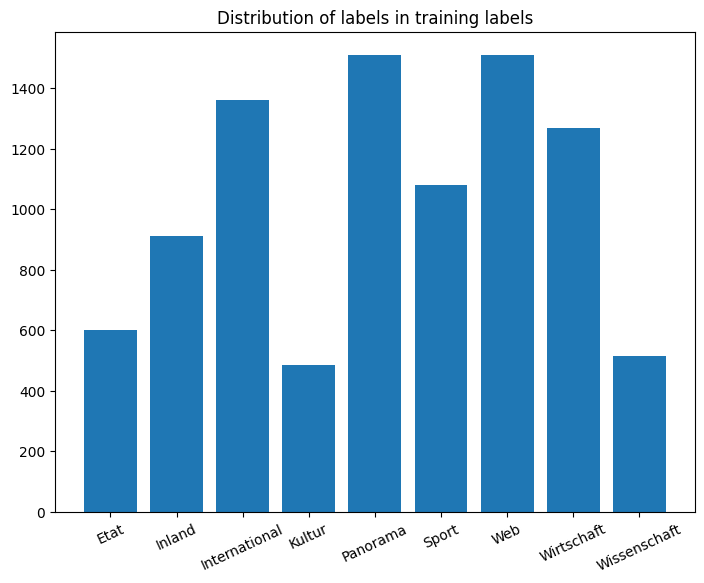

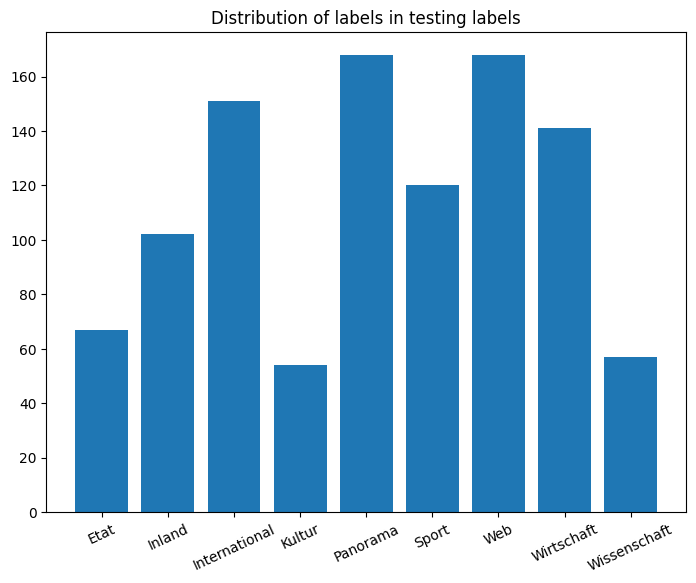

In [ ]:
if not skip_preprocessing:
  from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
  import matplotlib.pyplot as plt

  # Analyze Train labels
  labels_train = data_train[['label']]
  enc_ord = OrdinalEncoder()
  labels_train_ord = enc_ord.fit_transform(labels_train)

  label_classes = enc_ord.categories_
  num_distinct_classes = [len(classes) for classes in label_classes][0]

  bins = np.bincount(labels_train_ord.flatten().astype('int'))
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  ax.bar(categories_str, bins)
  plt.xticks(rotation=25)
  plt.title("Distribution of labels in training labels")
  plt.show()

  # Analyze Test labels
  labels_test = data_test[['label']]
  labels_test_ord = enc_ord.transform(labels_test)

  bins = np.bincount(labels_test_ord.flatten().astype('int'))
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  ax.bar(categories_str, bins)
  plt.xticks(rotation=25)
  plt.title("Distribution of labels in testing labels")
  plt.show()

Articles 'Etat', 'Kultur' und 'Wissenschaft' are less representative.
Distribution of train- und test-datasets are similar.

In [ ]:
# One hot encode and save labels
if not skip_preprocessing:
  enc_1hot = OneHotEncoder()
  labels_train_1hot = enc_1hot.fit_transform(labels_train_ord)
  labels_test_1hot = enc_1hot.fit_transform(labels_test_ord)
  y_train = labels_train_1hot.toarray()
  y_test = labels_test_1hot.toarray()

  os.chdir(path_data)
  np.save('data/y_train.npy', y_train)
  np.save('data/y_test.npy', y_test)

In [ ]:
# Clean text
import re

RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
RE_TAGS = re.compile(r"<[^>]+>")
RE_ASCII = re.compile(r"[^A-Za-zÀ-ž,.!? ]", re.IGNORECASE)
RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž,.!?]\b", re.IGNORECASE)

def clean_text(text):
    """
        - remove any html tags (< /br> often found)
        - Keep only ASCII + European Chars and whitespace, no digits
        - remove single letter chars
        - convert all whitespaces (tabs etc.) to single wspace
    """

    text = re.sub(RE_TAGS, " ", text)
    text = re.sub(RE_ASCII, " ", text)
    text = re.sub(RE_SINGLECHAR, " ", text)
    text = re.sub(RE_WSPACE, " ", text)
    return text

if not skip_preprocessing:
  data_train_clean = data_train["text_original"].map(clean_text)
  data_test_clean = data_test["text_original"].map(clean_text)
  print([data_train["text_original"].head(8), data_train_clean.head(8)])

[0    21-Jähriger fällt wohl bis Saisonende aus. Wie...
1    Erfundene Bilder zu Filmen, die als verloren g...
2    Der frischgekürte CEO Sundar Pichai setzt auf ...
3    Putin: "Einigung, dass wir Menge auf Niveau vo...
4    Estland sieht den künftigen österreichischen P...
5    Der Welser Stempelhersteller verbreitert sich ...
6    Traditionsklub setzt sich gegen den FC Utrecht...
7    Finanzausschuss tagte Montag: Konfliktthemen S...
Name: text_original, dtype: object, 0     Jähriger fällt wohl bis Saisonende aus. Wien ...
1    Erfundene Bilder zu Filmen, die als verloren g...
2    Der frischgekürte CEO Sundar Pichai setzt auf ...
3    Putin Einigung, dass wir Menge auf Niveau von ...
4    Estland sieht den künftigen österreichischen P...
5    Der Welser Stempelhersteller verbreitert sich ...
6    Traditionsklub setzt sich gegen den FC Utrecht...
7    Finanzausschuss tagte Montag Konfliktthemen St...
Name: text_original, dtype: object]


In [ ]:
MAXLEN = 192

In [ ]:
import tqdm

if not skip_preprocessing:
  from transformers import BertTokenizer
  tokenizer = BertTokenizer.from_pretrained("bert-base-german-cased")

def tokenize(review):
    encoded = tokenizer.encode_plus(
        text=review,
        add_special_tokens=True,  # Add `[CLS]` and `[SEP]`
        max_length=MAXLEN,  # Max length to truncate/pad
        padding='max_length',  # Pad sentence to max length
        return_attention_mask=False,  # attention mask not needed for our task
        return_token_type_ids=False,
        truncation=True, )

    return encoded['input_ids']

if not skip_preprocessing:
  X_train = np.array([tokenize(review) for review in tqdm.tqdm(data_train_clean)])
  X_test = np.array([tokenize(review) for review in tqdm.tqdm(data_test_clean)])

# Save preprocessed tokens
  os.chdir(path_data)
  np.save('data/X_train.npy', X_train)
  np.save('data/X_test.npy', X_test)

100%|████████████████| 1028/1028 [00:07<00:00, 130.87it/s]


In [ ]:
import tensorflow as tf
from transformers import TFBertModel

def build_model(max_len=MAXLEN):
    """ add binary classification to pretrained model
    """
    input_word_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")

    bert_model = TFBertModel.from_pretrained("bert-base-german-cased", name='model_bert')
    encoder_outputs = bert_model(input_word_ids)

    last_hidden_state = encoder_outputs[0]
    #pooler_output = encoder_outputs[1]

    cls_embedding = last_hidden_state[:, 0, :]

    #x = tf.keras.layers.Dense(18, name = "fc2", activation='relu')(cls_embedding)
    x = tf.keras.layers.Dropout(0.1)(cls_embedding) # improves robustness
    stack = tf.keras.layers.Dense(9, name = "fc2")(x)

    output = tf.keras.layers.Activation('softmax')(stack)
    model = tf.keras.models.Model(inputs=input_word_ids, outputs=output)

    return model

In [ ]:
model = build_model(max_len=MAXLEN)
model.summary()

2023-10-14 16:19:00.916984: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22216 MB memory:  -> device: 0, name: NVIDIA A30, pci bus id: 0000:3b:00.0, compute capability: 8.0
2023-10-14 16:19:00.918143: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22216 MB memory:  -> device: 1, name: NVIDIA A30, pci bus id: 0000:af:00.0, compute capability: 8.0
2023-10-14 16:19:00.919211: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 22216 MB memory:  -> device: 2, name: NVIDIA A30, pci bus id: 0000:d8:00.0, compute capability: 8.0
2023-10-14 16:19:02.259113: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
Some weights of the PyTorch model were not used when initializing the TF 2.0 mo

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer)  [(None, 192)]            0         
                                                                 
 model_bert (TFBertModel)    TFBaseModelOutputWithPoo  109081344 
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             192, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                             

# Experiment 1: Overfit
- Uses only first 100 datasets
- TFBertModel: Freeze weights

In [ ]:
model.get_layer("model_bert").trainable = False
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer)  [(None, 192)]            0         
                                                                 
 model_bert (TFBertModel)    TFBaseModelOutputWithPoo  109081344 
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             192, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                             

In [ ]:
# Overfit
BATCH_SIZE = 64
EPOCHS = 40
LEARNING_RATE = 1e-3

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = "categorical_crossentropy"

model.compile(optimizer, loss=loss, metrics=["accuracy"]) # colab: , jit_compile=True

# create a validation data set with 5% of data
from sklearn.model_selection import train_test_split
X, X_val, y, y_val = train_test_split(X_train, y_train, test_size=0.05, random_state=42, stratify=y_train)

X_ = X[:100]
y_ = y[:100]
train_dataset = (tf.data.Dataset.from_tensor_slices((X_, y_))
                    .shuffle(buffer_size=len(X_), reshuffle_each_iteration=True)
                    #.repeat(EPOCHS)
                    .batch(BATCH_SIZE))
val_dataset = (tf.data.Dataset.from_tensor_slices((X_val, y_val))
                    .batch(BATCH_SIZE))

In [ ]:
path_model = path_data + '/models/'

In [ ]:
checkpoint_path=path_model + 'model_v1_overfit'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

hist_overfit = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    #steps_per_epoch=int(np.floor((len(train_ids) / BATCH_SIZE))),
    validation_data=val_dataset,
    verbose=1,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor="val_loss", verbose=1, patience=1, restore_best_weights=True),
               model_checkpoint_callback
               #tf.keras.callbacks.TensorBoard(f'logs/{datetime.now()}')
               ],
)

Epoch 1/40
2/2 [==============================] - 15s 5s/step - loss: 2.5579 - accuracy: 0.1100 - val_loss: 2.3252 - val_accuracy: 0.1620
Epoch 2/40
2/2 [==============================] - 3s 3s/step - loss: 2.2757 - accuracy: 0.1300 - val_loss: 2.1970 - val_accuracy: 0.2009
Epoch 3/40
2/2 [==============================] - 3s 3s/step - loss: 2.0204 - accuracy: 0.2000 - val_loss: 2.0948 - val_accuracy: 0.2419
Epoch 4/40
2/2 [==============================] - 3s 3s/step - loss: 1.9835 - accuracy: 0.2200 - val_loss: 2.0122 - val_accuracy: 0.2570
Epoch 5/40
2/2 [==============================] - 3s 3s/step - loss: 1.8474 - accuracy: 0.3100 - val_loss: 1.9383 - val_accuracy: 0.2959
Epoch 6/40
2/2 [==============================] - 3s 3s/step - loss: 1.7075 - accuracy: 0.4300 - val_loss: 1.8700 - val_accuracy: 0.3089
Epoch 7/40
2/2 [==============================] - 3s 2s/step - loss: 1.6319 - accuracy: 0.4600 - val_loss: 1.8098 - val_accuracy: 0.3369
Epoch 8/40
2/2 [========================

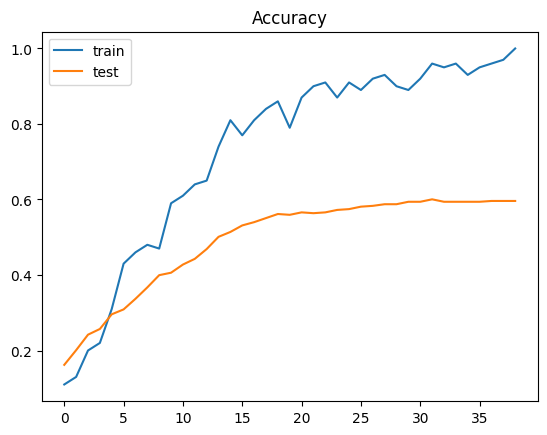

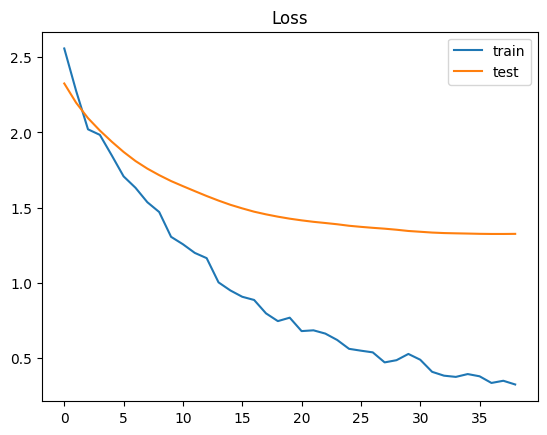

In [ ]:
plot_history(hist_overfit)

Reaches Accuracy of ~100%, performs worse on validation data.

# Experiment 2: AllData
- Uses 95% of training datasets to train, 5% to validate

In [ ]:
BATCH_SIZE = 64
EPOCHS = 40
LEARNING_RATE = 1e-3

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = "categorical_crossentropy"

model = build_model(max_len=MAXLEN)
model.get_layer("model_bert").trainable = False
model.compile(optimizer, loss=loss, metrics=["accuracy"]) # colab: , jit_compile=True
#model.load_weights(path_model + "model_v1_final", skip_mismatch=False, by_name=False, options=None)

model.summary()

# create a validation data set with 5% of data
from sklearn.model_selection import train_test_split
X, X_val, y, y_val = train_test_split(X_train, y_train, test_size=0.05, random_state=42, stratify=y_train)

X_ = X
y_ = y
train_dataset = (tf.data.Dataset.from_tensor_slices((X_, y_))
                    .shuffle(buffer_size=len(X_), reshuffle_each_iteration=True)
                    #.repeat(EPOCHS)
                    .batch(BATCH_SIZE))
val_dataset = (tf.data.Dataset.from_tensor_slices((X_val, y_val))
                    .batch(BATCH_SIZE))

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer)  [(None, 192)]            0         
                                                                 
 model_bert (TFBertModel)    TFBaseModelOutputWithPoo  109081344 
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             192, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                           

In [ ]:
checkpoint_path=path_model + "model_v1_allData"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

hist_allData = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    #steps_per_epoch=int(np.floor((len(train_ids) / BATCH_SIZE))),
    validation_data=val_dataset,
    verbose=1,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor="val_loss", verbose=1, patience=2, restore_best_weights=True),
               model_checkpoint_callback
               #tf.keras.callbacks.TensorBoard(f'logs/{datetime.now()}')
               ],
)

Epoch 1/40
138/138 [==============================] - 40s 230ms/step - loss: 1.2538 - accuracy: 0.5766 - val_loss: 0.8107 - val_accuracy: 0.7343
Epoch 2/40
138/138 [==============================] - 30s 214ms/step - loss: 0.7392 - accuracy: 0.7539 - val_loss: 0.7057 - val_accuracy: 0.7711
Epoch 3/40
138/138 [==============================] - 30s 216ms/step - loss: 0.6502 - accuracy: 0.7766 - val_loss: 0.6316 - val_accuracy: 0.7883
Epoch 4/40
138/138 [==============================] - 30s 216ms/step - loss: 0.6073 - accuracy: 0.7974 - val_loss: 0.6135 - val_accuracy: 0.7927
Epoch 5/40
138/138 [==============================] - 30s 216ms/step - loss: 0.5802 - accuracy: 0.7995 - val_loss: 0.5899 - val_accuracy: 0.8078
Epoch 6/40
138/138 [==============================] - 30s 216ms/step - loss: 0.5600 - accuracy: 0.8041 - val_loss: 0.5899 - val_accuracy: 0.8099
Epoch 7/40
138/138 [==============================] - 30s 216ms/step - loss: 0.5448 - accuracy: 0.8107 - val_loss: 0.5813 - val_ac

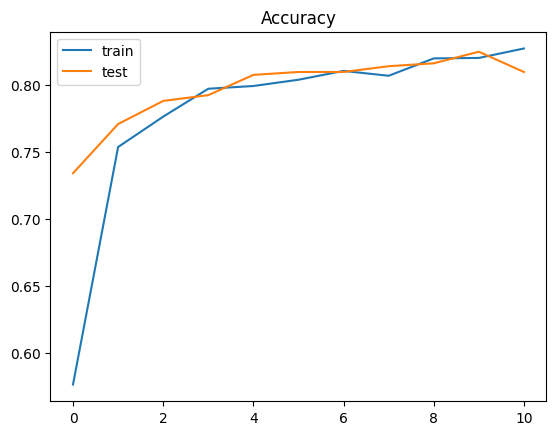

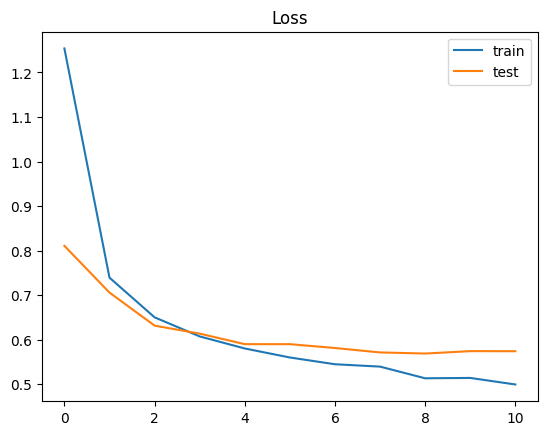

In [ ]:
plot_history(hist_allData)

Validation accuracy of 81%

# Experiment 3: FineTune
- Uses 95% of training datasets to train, 5% to validate
- Train all weights with low learningRate

In [ ]:
model.get_layer("model_bert").trainable = True
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer)  [(None, 192)]            0         
                                                                 
 model_bert (TFBertModel)    TFBaseModelOutputWithPoo  109081344 
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             192, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                           

In [ ]:
BATCH_SIZE = 64
EPOCHS = 40
LEARNING_RATE = 1e-6

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss ="categorical_crossentropy"


model.compile(optimizer, loss=loss, metrics=["accuracy"]) # colab: , jit_compile=True
#model.load_weights(path_model + "model_v1_final", skip_mismatch=False, by_name=False, options=None)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer)  [(None, 192)]            0         
                                                                 
 model_bert (TFBertModel)    TFBaseModelOutputWithPoo  109081344 
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             192, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                           

In [ ]:
checkpoint_path=path_model + "model_v1_fine"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

hist_fine = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    #steps_per_epoch=int(np.floor((len(train_ids) / BATCH_SIZE))),
    validation_data=val_dataset,
    verbose=1,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor="val_loss", verbose=1, patience=2, restore_best_weights=True),
               model_checkpoint_callback
               #tf.keras.callbacks.TensorBoard(f'logs/{datetime.now()}')
               ],
)

Epoch 1/40
138/138 [==============================] - 81s 509ms/step - loss: 0.4328 - accuracy: 0.8473 - val_loss: 0.4619 - val_accuracy: 0.8423
Epoch 2/40
138/138 [==============================] - 68s 493ms/step - loss: 0.3822 - accuracy: 0.8676 - val_loss: 0.4415 - val_accuracy: 0.8445
Epoch 3/40
138/138 [==============================] - 68s 492ms/step - loss: 0.3603 - accuracy: 0.8744 - val_loss: 0.4187 - val_accuracy: 0.8423
Epoch 4/40
138/138 [==============================] - 68s 493ms/step - loss: 0.3313 - accuracy: 0.8849 - val_loss: 0.4073 - val_accuracy: 0.8488
Epoch 5/40
138/138 [==============================] - 68s 492ms/step - loss: 0.3182 - accuracy: 0.8867 - val_loss: 0.3975 - val_accuracy: 0.8445
Epoch 6/40
138/138 [==============================] - 65s 472ms/step - loss: 0.2944 - accuracy: 0.8972 - val_loss: 0.3979 - val_accuracy: 0.8510
Epoch 7/40
138/138 [==============================] - 65s 474ms/step - loss: 0.2823 - accuracy: 0.8991 - val_loss: 0.3977 - val_ac

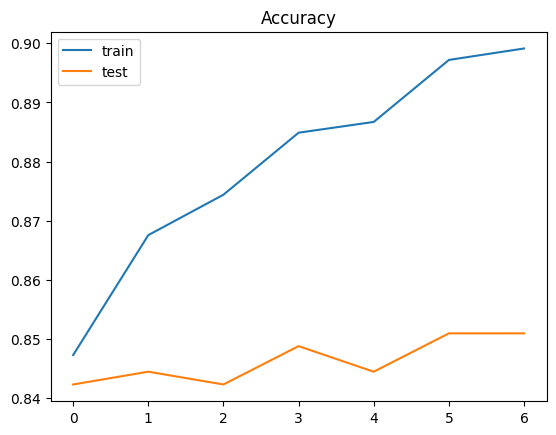

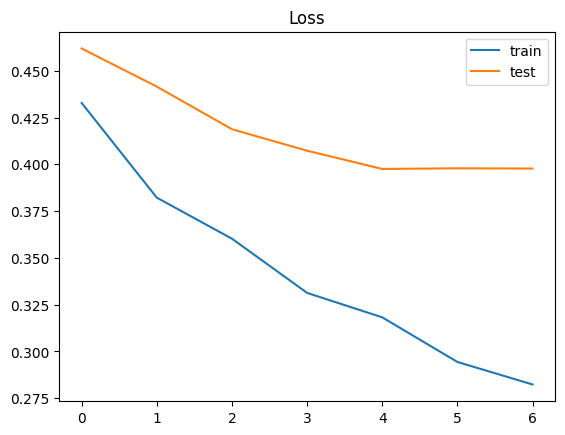

In [ ]:
plot_history(hist_fine)

# Evaluation

In [ ]:
%%time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)
labels = np.load('data/classes.npy')

y_pred_class = np.argmax(y_pred, axis=1)
y_test_class = np.argmax(y_test, axis=1)

accuracy_score(y_test_class, y_pred_class)

cm = confusion_matrix(y_test_class, y_pred_class)
print(cm)
print(labels)

[[ 49   5   1   4   1   0   4   3   0]
 [  1  86   2   2   4   0   0   6   1]
 [  0   0 132   0  12   1   1   4   1]
 [  0   0   0  48   2   0   2   1   1]
 [  2   8  11   1 134   0   1   7   4]
 [  0   0   0   0   1 119   0   0   0]
 [  1   0   2   0   0   0 162   3   0]
 [  0   4   0   0   6   0   4 127   0]
 [  0   1   1   0   2   0   0   3  50]]
['Etat' 'Inland' 'International' 'Kultur' 'Panorama' 'Sport' 'Web'
 'Wirtschaft' 'Wissenschaft']
CPU times: user 4.43 s, sys: 444 ms, total: 4.88 s
Wall time: 4.99 s


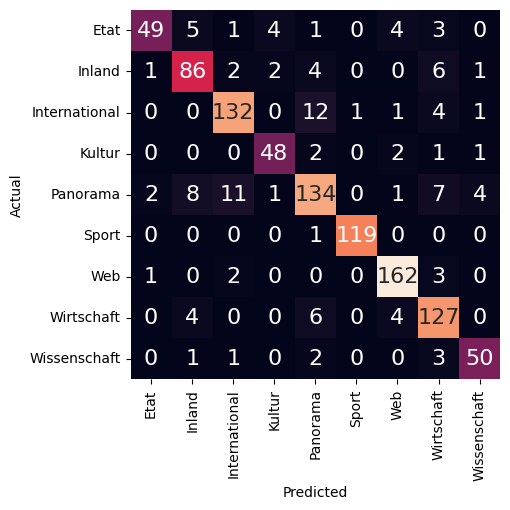

               precision    recall  f1-score   support

         Etat       0.92      0.73      0.82        67
       Inland       0.83      0.84      0.83       102
International       0.89      0.87      0.88       151
       Kultur       0.87      0.89      0.88        54
     Panorama       0.83      0.80      0.81       168
        Sport       0.99      0.99      0.99       120
          Web       0.93      0.96      0.95       168
   Wirtschaft       0.82      0.90      0.86       141
 Wissenschaft       0.88      0.88      0.88        57

     accuracy                           0.88      1028
    macro avg       0.88      0.87      0.88      1028
 weighted avg       0.88      0.88      0.88      1028



In [ ]:
import seaborn as sn

df_cm = pd.DataFrame(cm, labels, labels)
ax = sn.heatmap(df_cm, annot=True, annot_kws={'size': 16}, square=True, cbar=False, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
#ax.invert_yaxis() #optional
plt.show()

from sklearn.metrics import classification_report

print(classification_report(y_test_class, y_pred_class, target_names=labels))